# Monte Carlos Simulations - Physical Models
In this notebook, we'll be continuing our previous work with Monte Carlos simulations. This time, we'll move from studying networks to looking at a variety of models from physics (which often have applications to social sciences, economics, and finance).

## Objectives
<ul>
<li> Learn data structures and monte carlo techniques for efficient simulations on networked structures. </li>
<li> Learn how to generalize models for new systems</li>
</ul>


## Percolation models
The first type of model we'll look at is the well known Percolation model. Percolation models describe the behavior of of connected clusters in a random graph. 


You'll notice some similarity to the epidemic models we looked at in the previous notebook, and indeed, theoretical results from percolation theory can be used to describe epidemic propagation on graphs. You can check out this <a href = "http://arxiv.org/abs/1405.0483">paper</a> by <a href = "http://www-personal.umich.edu/~mejn/"> Mark Newman</a> for an example of these kinds of studies.
Percolation theory in general can be used to make a priori predictions about a contagion spreading over some probabilistically porous material. Ex: a forest fire for example, where the propability of the fire growing out of control is a function of the tree density, as makes sense intuitively.

There are <a href = "https://en.wikipedia.org/wiki/Percolation_theory"> many kinds of percolation models </a>, but in this notebook, we'll limit ourselves to studying Site Percolation. This is where we model a system with empty cells - each cell has a probability $p$ of being occupied.

We'll be using the UnionFind data structure to help perform this task efficiently. Read the documentation for more info (Code taken from the personal page of Professor David Eppstein at UC Irvine (<a href = "https://www.ics.uci.edu/~eppstein/PADS/UnionFind.py">here</a>)).

In [2]:
class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

Great, so now we just need to define a percolation class:

In [3]:
import random as rd
class Percolation:
    
    #generate init_size x init_size lattice with all cells originally empty
    def __init__(self, init_size = 100):
        self.cells = [[False]*init_size]*init_size;
        self.size = init_size
        self.source = (0, 0)
        self.target = (init_size, init_size)
        self.unionf = UnionFind()
        self.unoccupied = set()
        for i in range(init_size):
            self.unionf.union(self.target, (init_size-1, i));
            self.unionf.union(self.source, (0, i));
        
        for i in range(init_size):
            for j in range(init_size):
                self.unoccupied.add((i, j))
                
    def get_neighbors(self, i, j):
        neighbors = set();
        for diff in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
            nx = i + diff[0];
            ny = j + diff[1];
            if (nx < self.size and nx >= 0) and (ny < self.size and ny >= 0):
                neighbors.add((nx, ny));
        return neighbors;
    
    #Select Neighbor randomly picks a neighbor to have the site occupied, and connects
    # the neighbors that are also occupied
    def select_neighbor(self):
        fill = rd.choice(list(self.unoccupied));
        self.cells[fill[0]][fill[1]] = True;
        self.unoccupied.discard(fill);
        neighbors = self.get_neighbors(fill[0], fill[1]);
        for nbor in neighbors:
            if (self.cells[nbor[0]][nbor[1]]):
                self.unionf.union(nbor, fill)
    
    def percolate(self):
        while (self.unionf[self.source]!= self.unionf[self.target]):
            self.select_neighbor();
        return self.size*self.size - len(self.unoccupied);
                    

            
            


In [9]:
p = Percolation(100); p.percolate()

2974

In [12]:
class MCPercolation:
    '''fill in this class to record some statistics on the Percolation model and determine 
    the empirical probability of percolation'''
    pass

# Ising Model
The Ising model comes from statistical mechanics and is used to model ferromagnetism. Originally proposed in 1924 by William Lenz, the model consists of a lattice of states with either positive or negative spin. These spins are allowed to interact with their neighbors and in the general case, are placed in a field. The object is to find a configuration $\sigma$ of spins which will minimize the total energy of the system:
$$ E(\sigma) = - \sum_{\left< i, j \right>} J_{ij}\sigma_i\sigma_j - \mu \sum_j h_j\sigma_j $$
Here $\left< i, j \right>$ describes a neighborign pair, $J_{ij}$ describes the interaction energy between $i$ and $j$, $\sigma_i$ and $\sigma_j$ are the signs of the spins, and $\mu$ is the magnetic moment. $h_j$ describes the magnetic field strength at site $j$.

While this is the original context of the Ising Model, you can think of it as a general way for representing a network of interacting agents. We're going to work in that context, and develop a model for a financial asset traded by a market of locally interacting agents. If you're curious about this kind of work, google searching "ising model finance" will lead you to a decent collection of papers.

We'll be working with the paper from here: http://przyrbwn.icm.edu.pl/APP/PDF/114/a114z305.pdf

In [13]:
import random as rd;
import numpy as np;
class IsingFinance:
    
    '''transition_func takes in the interaction (J) and individual 
        opinion (sigma) parameters as well as a threshold parameter t 
        and returns a function that takes in a list [s_i] of neighboring decisions
        from the previous time step and Mt, the aggregate decision direction ([-1, 1])
    '''
    @staticmethod
    def get_transition_func(J, sigma, t):
        def transition(decisions, Mt):
            raw = 0.0;
            for dec in decisions:
                raw+= J*dec;
            raw+= sigma*np.random.normal();
            sig = 0;
            if (raw > t):
                sig = 1;
            elif (raw < -t):
                sig = -1;
            return sig;
        return transition
                
    def __init__(self, tfunc, N=32,):
        self.lattice = []
        self.tfunc = tfunc;
        self.N = N;
        self.aggregate = 0.0;
        for i in range(N):
            row = [];
            for j in range(N):
                val = rd.choice([-1, 0, 1]);
                row.append(val);
                self.aggregate+=float(val)
            self.lattice.append(row);
        self.aggregate = self.aggregate/float(N*N);
        
    def get_neighbors(self, i, j):
        neighbors = [];
        for diff in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
            nx = i + diff[0]; ny = j + diff[1];
            if (nx < self.N and nx >= 0) and (ny < self.N and ny >= 0):
                neighbors.append(self.lattice[nx][ny]);
        return neighbors;
    
    def update_state(self):
        tfunc = self.tfunc;
        newlattice = [];
        newagg = 0.0
        for i in range(self.N):
            newrow = [];
            for j in range(self.N):
                val = tfunc(self.get_neighbors(i, j), self.aggregate)
                newrow.append(val);
                newagg+=val
        oldagg = self.aggregate;
        self.aggregate = newagg/(self.N* self.N);
        return (self.aggregate, oldagg);
    
    def generate_time_series(self, time=10000, burn_in=1000):
        while (burn_in > 0):
            self.update_state();
            burn_in-=1;
        
        curr = 100
        tseries = []
        while (time > 0):
            val = self.update_state();
            tseries.append(val[0]);
            time-=1;
        return tseries;
        
                
                
                
            

In [14]:
model = IsingFinance(IsingFinance.get_transition_func(1, 1, 3))

In [15]:
tseries = model.generate_time_series();

Now we've generated a time series of the returns, let's look at this time series and perform some analysis.

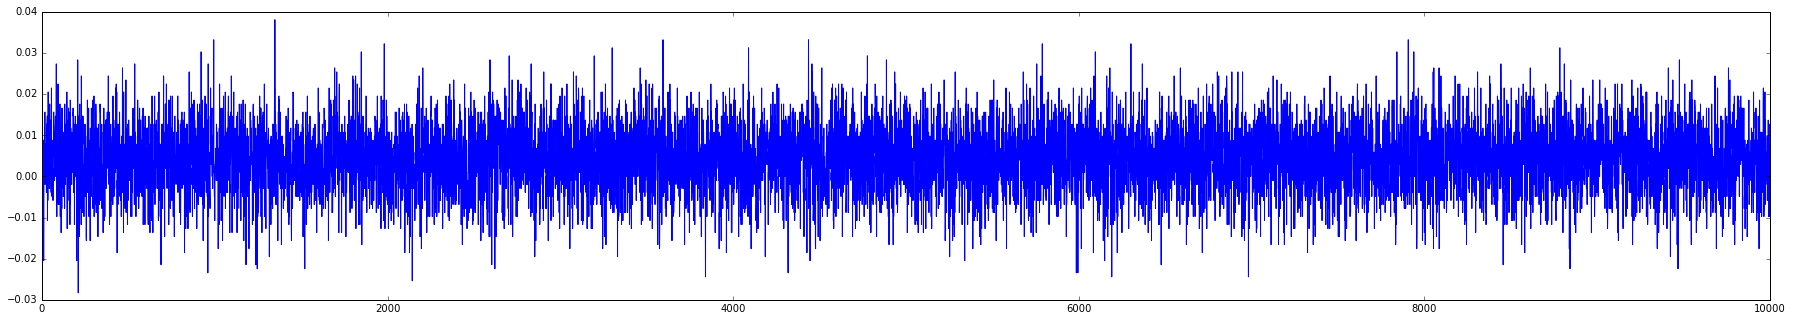

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = plt.axes([0, 0.6, 4, 1])
ax.plot(tseries)

In [17]:
price = 100;
pxs = [100];
for r in tseries:
    price = (1.0+r/100.0)*price;
    pxs.append(price);
    

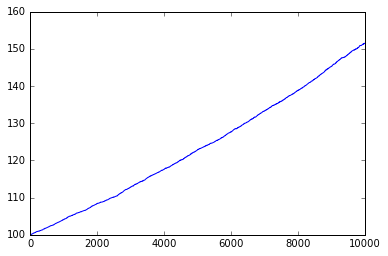

In [18]:
plt.plot(pxs)

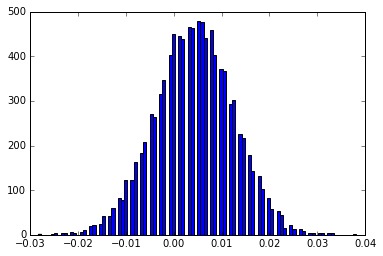

In [19]:
plt.hist(tseries, bins = 100);

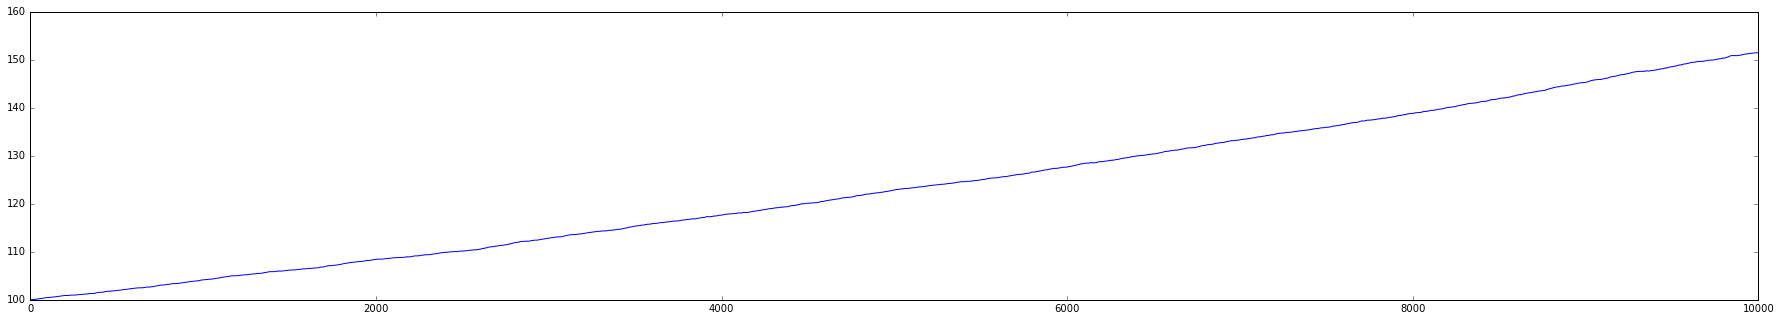

In [20]:
ax2 = plt.axes([0, 0.6, 4, 1])
ax2.plot(pxs)

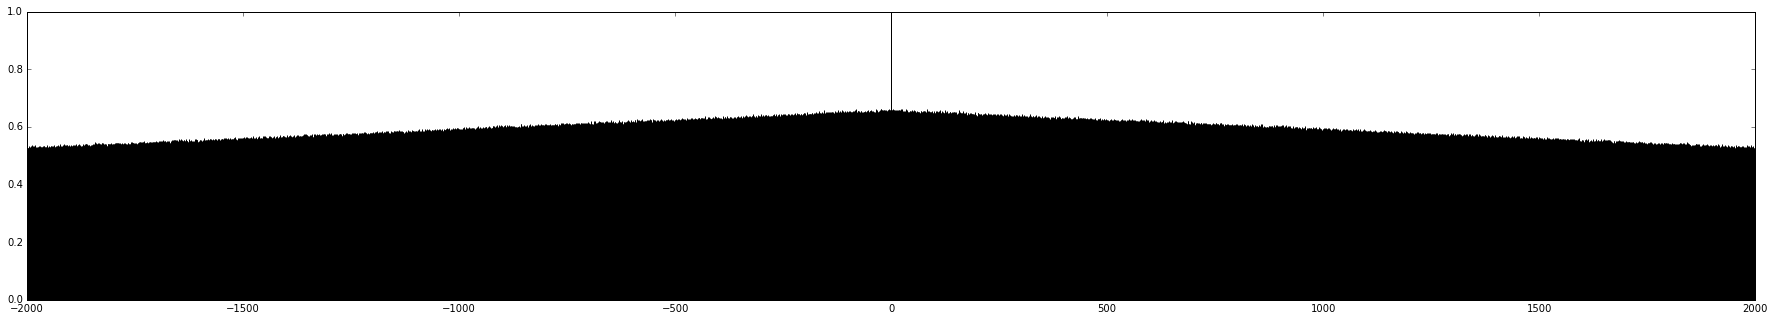

In [208]:
ax3 = plt.axes([0, 0.6, 4, 1])
ax3.acorr(tseries, maxlags = 2000);

What happens when you play with different parameters? Strengthening collaboration for example?
Experiment with different settings. Do you see any evidence of <a href ="https://en.wikipedia.org/wiki/Volatility_clustering"> voltatility clusters? </a>

file:///Users/Nitin/Downloads/bptx_2010_2__0_292817_0_110160%20(1).pdf

In [106]:
#Experiment here

Schelling Segregation is a similar model to the Ising Model. Economist <a href="https://en.wikipedia.org/wiki/Thomas_Schelling">Thomas Schelling</a> created the <a href = "https://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf">model</a> in the 1970s to explain the persistence of racial and economic segregation on the basis of individual preferences. 
You can check out a description and a cool simulation here:
http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/
